# Infant eating and sleeping patterns

I have a friend who uses an app to keep track of her infant's eating and sleeping schedule.  Because she is breastfeeding, the baby's eating habits can be unpredictable, but in principle, keeping track of the data could help identify patterns of behavior (haha, as if babies could be predicted!)

I have the exported data from the app as a CSV of timestamped periods of eating and sleeping, including whether the baby nursed on the left/right side or ate from a bottle, and if so, how many oz of milk were used.  I'm hoping to use
this data to answer questions of interest like:

* Has the baby shown changes in patterns of feedings/sleeping as time progresses?
* Does the baby tend to nurse on both sides more often (thus consuming more milk at a time) as the months have passed?
* Does the baby tends to nap longer immediately following a feeding?
* Do the number of naps or cumulative napping time have an impact on the number/frequency of nighttime wakings?

For now, I will focus on the first question, looking at patterns in feedings over time.

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
df = pd.read_csv('NursingData_clean.csv')

In [4]:
df['time'] = pd.to_datetime(df['time'])
date = [x.strftime('%Y %m %d') for x in df['time']]
df['Date'] = date
df[:5]

,Unnamed: 0,time,Year,Month,TimeofDay,LeftFeed,RightFeed,BotFeed,TotalFeed,BotAmt,Sleep,Date
0,0,2015-06-21 01:17:09,2015,6,Late night,0.00,1.3,0,1.30,NaN,NaN,2015 06 21
1,1,2015-06-21 02:00:39,2015,6,Late night,7.52,0.0,0,7.52,NaN,NaN,2015 06 21
2,2,2015-06-21 02:37:57,2015,6,Late night,14.50,0.0,0,14.50,NaN,NaN,2015 06 21
3,3,2015-06-21 05:23:55,2015,6,Late night,0.00,20.0,0,20.00,NaN,NaN,2015 06 21
4,4,2015-06-21 05:47:59,2015,6,Late night,22.18,0.0,0,22.18,NaN,NaN,2015 06 21


# Fitting Timeseries Data

### Exploring the data set.
First I just want to plot the data to have a look and see what we're dealing with here.  I'll try a couple of different plotting types.  The data include all of the feeding sessions from June through February.  In order to make a little more sense of the it, I have selected only the entries that have feeding data (rather than sleeping data) and then used the .groupby method to group each set of data by date.  

After I have all the feeding data grouped per day, I calculate the total minutes spent feeding the baby per day, the average length of a feeding session, and the standard deviation on that mean.

In [5]:
eat = df[df['TotalFeed'].notnull()]
rm15 = eat[eat['TotalFeed'] != 15.]
bydate = eat.groupby(eat['Date'])
rm15byd = rm15.groupby(eat['Date'])
bydun = bydate.sum().unstack()

In [6]:
tots = bydate['TotalFeed'].sum()
means = rm15byd['TotalFeed'].mean()
number = bydate['TotalFeed'].count()
err = [bydate['TotalFeed'].std()[i]/math.sqrt(n) for i,n in enumerate(number)]

Because I will be fitting this data, I need to turn the dates into numerical data in order to fit it and plot the fit.  While I'm at it, I will create an array of the numerical dates for plotting the fit function, and convert those from float types back to datetime type elements, so my axes read the correct values.

In [7]:
x = [datetime.strptime(d,'%Y %m %d').date() for d in bydun['TotalFeed'].index]
xnum = mdates.date2num(x)
xx = np.linspace(xnum.min(), xnum.max(), 100)
dd = mdates.num2date(xx)

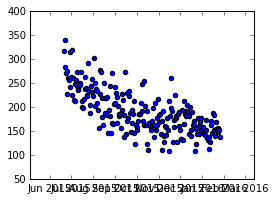

In [46]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.scatter(x,tots)
fig.savefig('test.pdf',bbox_inches='tight')

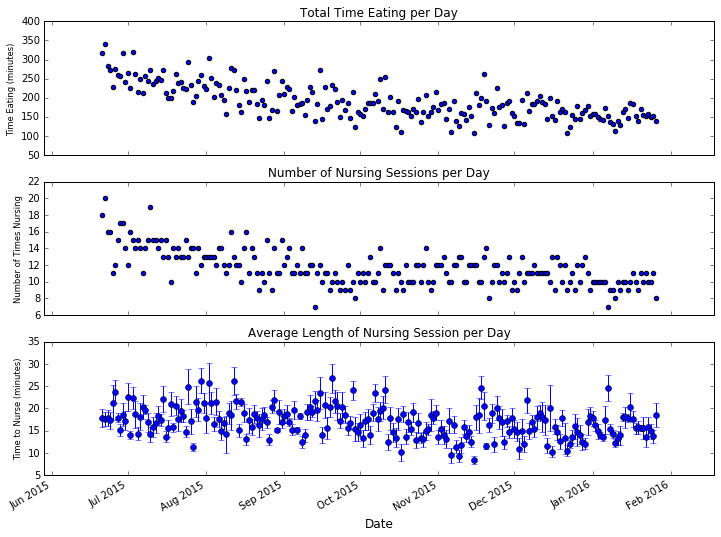

In [53]:
fig = plt.figure(figsize=(12,9))

ax = fig.add_subplot(311)
ax.scatter(x,tots)
ax.set_title('Total Time Eating per Day')
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Time Eating (minutes)',fontsize='small')

ax2 = fig.add_subplot(313, sharex=ax)
ax2.errorbar(x,means,yerr=err,fmt='o')
ax2.set_title('Average Length of Nursing Session per Day')
ax2.set_xlabel('Date',fontsize='large')
ax2.set_ylabel('Time to Nurse (minutes)',fontsize='small')

ax3 = fig.add_subplot(312, sharex=ax)
ax3.scatter(x,number)
ax3.set_title('Number of Nursing Sessions per Day')
ax3.set_xlabel('Date',fontsize='large')
ax3.set_ylabel('Number of Times Nursing',fontsize='small')

fig.autofmt_xdate()
plt.show()
fig.savefig('TotNMean.png',bbox_inches='tight')

There are a few things to notice in this data.  First, there definitely seems to be a decrease in the total time spent eating each day, which means the baby is becoming a more efficient eater.  As you would expect, there is likewise a decrease in the number of nursing sessions per day.  The lessening scatter in the average length of nursing sessions shows that the baby's habits are becoming more consistent with time.  

Let's look a little more in depth at the first set of data - total time spent eating.  First, I'll try a couple of different ways of visualizing the data.

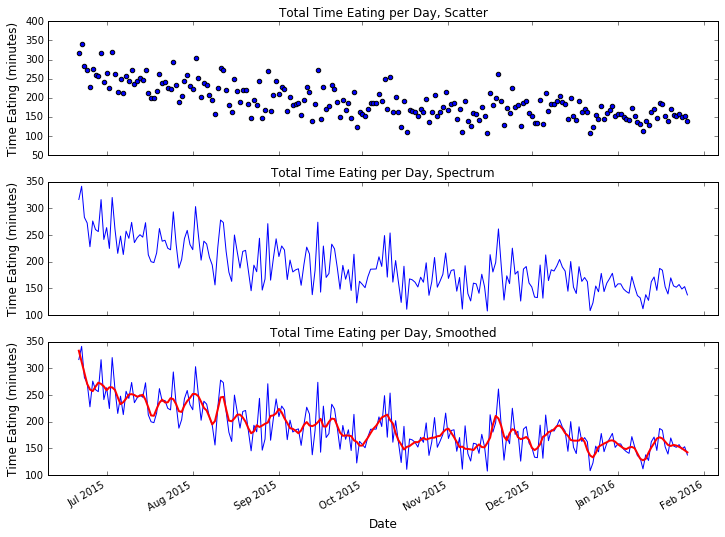

In [56]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(311)

#ax.errorbar(x,tots,yerr=errs,fmt='o')#plot data
ax.scatter(x,tots)
ax.set_title('Total Time Eating per Day, Scatter')
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Time Eating (minutes)',fontsize='large')

ax2 = fig.add_subplot(312, sharex=ax)
ax2.plot(x,tots)#plot data
ax2.set_title('Total Time Eating per Day, Spectrum')
ax2.set_xlabel('Date',fontsize='large')
ax2.set_ylabel('Time Eating (minutes)',fontsize='large')

filtered = lowess(tots, xnum, is_sorted=True, frac=0.035, it=0)

ax3 = fig.add_subplot(313, sharex=ax)
ax3.plot(xnum,tots,'b')
ax3.plot(filtered[:,0], filtered[:,1], 'r',linewidth=2)
ax3.set_title('Total Time Eating per Day, Smoothed')
ax3.set_xlabel('Date',fontsize='large')
ax3.set_ylabel('Time Eating (minutes)',fontsize='large')

fig.autofmt_xdate()
plt.savefig('TimeEating_varplots.png',dpi=150,bbox_inches='tight')

In the top plot, we have the original scatter plot.  Below is the same data plotted with no markers and connected lines, which I've labeled "spectrum".  In the bottom plot, I tried smoothing the data just to see how it would look.  I think the most useful information is included in the spectrum version. One of the important aspects of this data set is not just the broad patterns we can see, but how wildly the totals swing from day to day. That is visualized best in the middle plot, so I will continue to use it from now on.

For this data, it's obvious there is a downward trend with time. It would be useful to fit this trend, and use the fit as a prediction for the baby's future behavior.  In particular, we can estimate the date when the baby would naturally self-wean if the decreasing trend continues.  The trend doesn't strike me as quite linear (a 1-degree polynomial), so first I'll try a 2-degree (parabolic) polynomial fit, using the converted dates as x values.  It's best practice when using polynomial fits to use as few degrees of freedom as possible to obtain a good fit to the data, in part because using too many degrees of freedom can result in a fit based largely on noise and not meaningful trends in the data.

In [10]:
z2 = np.polyfit(xnum,bydun['TotalFeed'],2)
p2 = np.poly1d(z2)

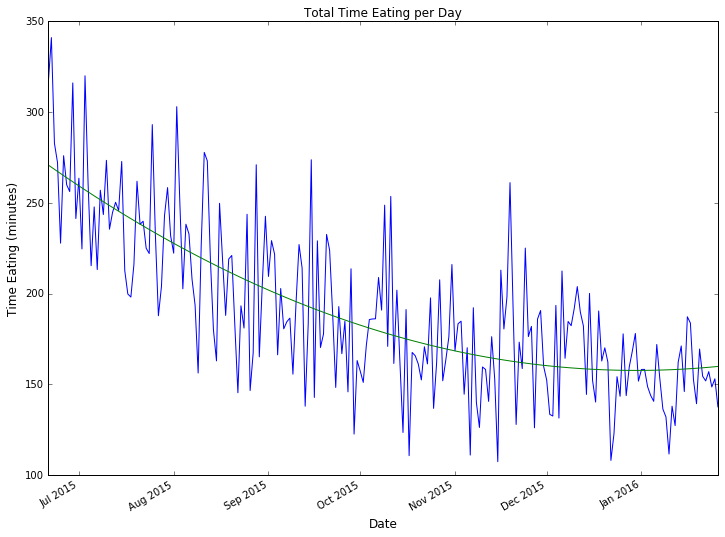

In [57]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)

ax.errorbar(xnum,bydun['TotalFeed'])#,yerr=errs, fmt='o') 
plt.plot(dd, p2(xx), '-g') #plot fit

ax.set_title('Total Time Eating per Day')
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Time Eating (minutes)',fontsize='large')
fig.autofmt_xdate()
plt.savefig('TimeEat_parabolic.png',bbox_inches='tight')

In [12]:
 def redchisqg(ydata,ymod,deg=2,sd=None):  
      """  
 Returns the reduced chi-square error statistic for an arbitrary model,   
 chisq/nu, where nu is the number of degrees of freedom. If individual   
 standard deviations (array sd) are supplied, then the chi-square error   
 statistic is computed as the sum of squared errors divided by the standard   
 deviations. See http://en.wikipedia.org/wiki/Goodness_of_fit for reference.  
   
 ydata,ymod,sd assumed to be Numpy arrays. deg integer.  
   
 Usage:  
 >>> chisq=redchisqg(ydata,ymod,n,sd)  
 where  
  ydata : data  
  ymod : model evaluated at the same x points as ydata  
  n : number of free parameters in the model  
  sd : uncertainties in ydata  
   
 Rodrigo Nemmen  
 http://goo.gl/8S1Oo  
       """  
      # Chi-square statistic  
      if sd==None:  
           chisq=np.sum((ydata-ymod)**2)  
      else:  
           chisq=np.sum( ((ydata-ymod)/sd)**2 )  
             
      # Number of degrees of freedom assuming 2 free parameters  
      nu=ydata.size-1-deg  
        
      return chisq/nu 

You can see at the far right edge that the parabolic fit is starting to curve upward again.  Since the data will not curve back upward, this is a non-physical fit.  A power law would be a more physically motivated fit.  Let's do this by converting to log space and performing a least squares fit, then converting back to regular coordinates.

A power law fit is expressed as: 
y = a + x^b.  
In logarithmic space, that becomes:
log(y) = log(a) + b * log(x).

I also calculate the reduced chi-squared of the fits, in order to quantitatively compare fitting methods.

In [13]:
logxnum = np.log10(xnum)
logy = np.log10(tots)

In [14]:
linfit = np.polyfit(logxnum,logy,1)
plin = np.poly1d(linfit)
logxx = np.linspace(logxnum.min(), logxnum.max(), 100)
logyfit = linfit[0]*logxnum + linfit[1]
logyy = linfit[0]*logxx + linfit[1]

In [15]:
rchi2 = redchisqg(tots,p2(xnum))
logchi2 = redchisqg(10**logy,10**logyfit)

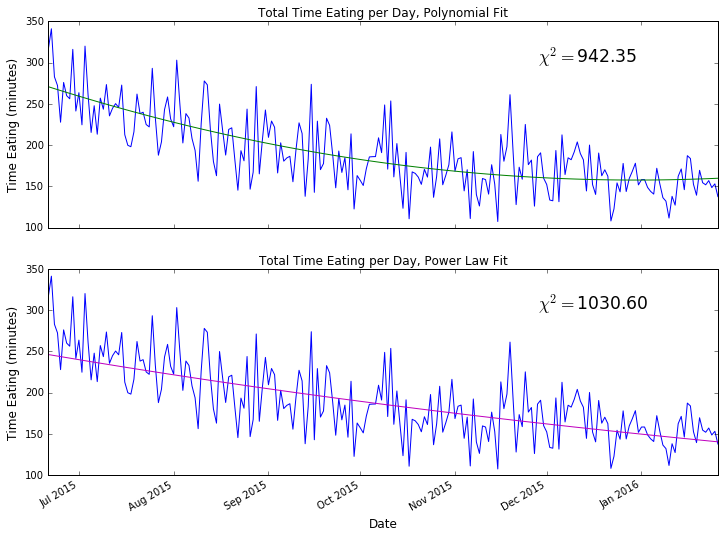

In [58]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(211)

ax.plot(xnum,bydun['TotalFeed'])#plot data
plt.plot(dd, p2(xx), '-g') #plot fit
ax.annotate(r'$\chi^2=$'+str("%0.2f" %rchi2),xy=(xnum[160],300),size='xx-large')
ax.set_title('Total Time Eating per Day, Polynomial Fit')
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Time Eating (minutes)',fontsize='large')

ax2 = fig.add_subplot(212)
ax2.plot(xnum,bydun['TotalFeed'])#plot data
plt.plot(x, 10.**logyfit, '-m') #plot fit
ax2.annotate(r'$\chi^2=$'+str("%0.2f" %logchi2),xy=(xnum[160],300),size='xx-large')
ax2.set_title('Total Time Eating per Day, Power Law Fit')
ax2.set_xlabel('Date',fontsize='large')
ax2.set_ylabel('Time Eating (minutes)',fontsize='large')
#plt.xlim(datetime(2016,1,1),datetime(2016,2,1))
fig.autofmt_xdate()
plt.savefig('TimeEat_ParabvPL.png',bbox_inches='tight')

Surprisingly, the power law actually fits worse than the polynomial.  You can tell by eye, but the $\chi^2$ bears this out as well.  Just to check, I want to see the fit in log space to make sure everything worked correctly.  (Note:  fit parameters are listed highest degree to lowest, so x*fit[0] + fit[1].)

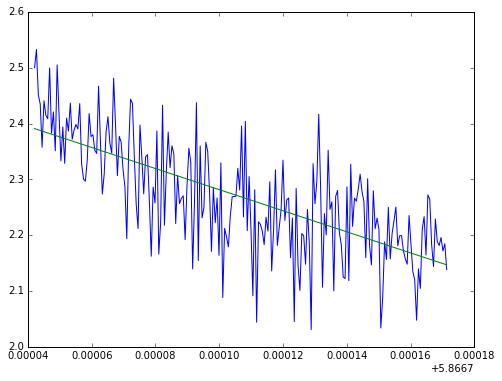

In [30]:
fig = plt.figure(figsize=(8,6))
plt.plot(logxnum,logy)
plt.plot(logxx,logyy)
plt.savefig('TimeEat_log.jpg',bbox_inches='tight')

You can see an inflection point in the data even in log space (around x=0.00011), so the linear fit here isn't that great of a model.  This explains why the power law in linear space didn't fit as well as the polynomial.  

The next step is to try fitting a broken line to the data.  I'm going to break the data into two sections at Oct 18, 2015.  While this is motivated by the data, which appears to change its rate of descent around there, it is also physically motivated.  At an age of four months, the baby started eating solids in addition to nursing, so it makes sense that the nursing pattern would change around that point.

After trying a broken linear fit, I will add more current data to see if the broken line model fits the added data.

In [18]:
x1 = [datetime.strptime(d,'%Y %m %d').date() for d in bydun['TotalFeed'].index if d < '2015 10 18']
x2 = [datetime.strptime(d,'%Y %m %d').date() for d in bydun['TotalFeed'].index if d >= '2015 10 18']
y1 = [bydun.TotalFeed[i] for i,d in enumerate(bydun['TotalFeed'].index) if d < '2015 10 18']
y2 = [bydun.TotalFeed[i] for i,d in enumerate(bydun['TotalFeed'].index) if d >= '2015 10 18']
xnum1 = mdates.date2num(x1)
xnum2 = mdates.date2num(x2)
xx1 = np.linspace(xnum1.min(), xnum1.max(), 100)
xx2 = np.linspace(xnum2.min(), xnum2.max(), 100)
dd1 = mdates.num2date(xx1)
dd2 = mdates.num2date(xx2)

z2_1 = np.polyfit(xnum1,y1,1)
p2_1 = np.poly1d(z2_1)
z2_2 = np.polyfit(xnum2,y2,1)
p2_2 = np.poly1d(z2_2)

totfit = []
totfit = list(p2_1(xnum1))
for val in p2_2(xnum2):  totfit.append(val)
    
bchi2 = redchisqg(tots,totfit)

In [19]:
dfnew = pd.read_csv('NursingData_3-1_clean.csv')
dfnew['time'] = pd.to_datetime(dfnew['time'])
datenew = [x.strftime('%Y %m %d') for x in dfnew['time']]
dfnew['Date'] = datenew
eatnew = dfnew[dfnew['TotalFeed'].notnull()]
bydatenew = eatnew.groupby(eatnew['Date'])
bydunnew = bydatenew.sum().unstack()
totsnew = bydatenew['TotalFeed'].sum()
x2new = [datetime.strptime(d,'%Y %m %d').date() for d in bydunnew['TotalFeed'].index if d >= '2015 10 18']
xnum2new = mdates.date2num(x2new)
xnumnew = list(xnum1) + list(xnum2new)
totfitnew = list(p2_1(xnum1))
for val in p2_2(xnum2new):  totfitnew.append(val)
bchi2new = redchisqg(totsnew,totfitnew)
pfitnew = list(p2(xnum1))
for pval in p2(xnum2new): pfitnew.append(pval)
pchi2new = redchisqg(totsnew,pfitnew)

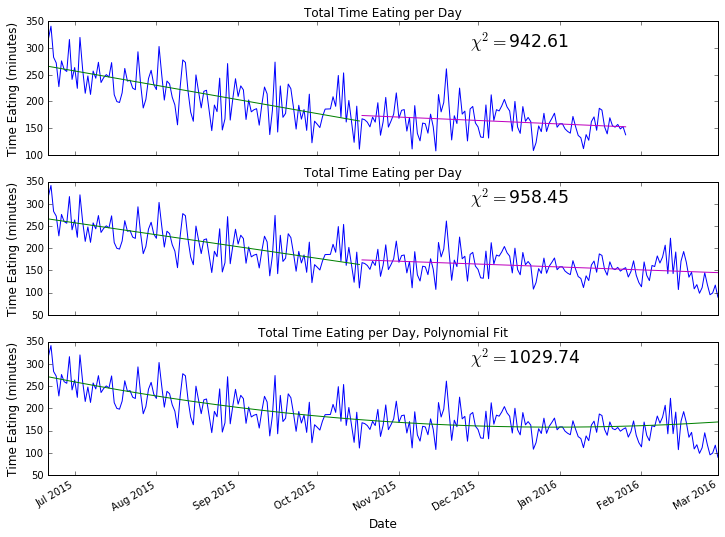

In [60]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(311)

ax.plot(xnum,bydun['TotalFeed'])
ax.plot(dd1, p2_1(xx1), '-g') #plot fit
ax.plot(dd2, p2_2(xx2), '-m') #plot fit
ax.annotate(r'$\chi^2=$'+str("%0.2f" %bchi2),xy=(xnum[160],300),size='xx-large')
ax.set_title('Total Time Eating per Day')
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Time Eating (minutes)',fontsize='large')
#plt.xlim(datetime(2015,6,18),datetime(2016,3,1))

ax2 = fig.add_subplot(312, sharex=ax)
ax2.plot(xnumnew,totsnew)
ax2.plot(dd1, p2_1(xx1), '-g') #plot fit
ax2.plot(xnum2new, p2_2(xnum2new), '-m') #plot fit
ax2.annotate(r'$\chi^2=$'+str("%0.2f" %bchi2new),xy=(xnumnew[160],300),size='xx-large')
ax2.set_title('Total Time Eating per Day')
ax2.set_xlabel('Date',fontsize='large')
ax2.set_ylabel('Time Eating (minutes)',fontsize='large')

ax3 = fig.add_subplot(313, sharex=ax)
ax3.plot(xnumnew,totsnew)#plot data
ax3.plot(xnumnew, p2(xnumnew), '-g') #plot fit
ax3.annotate(r'$\chi^2=$'+str("%0.2f" %pchi2new),xy=(xnum[160],300),size='xx-large')
ax3.set_title('Total Time Eating per Day, Polynomial Fit')
ax3.set_xlabel('Date',fontsize='large')
ax3.set_ylabel('Time Eating (minutes)',fontsize='large')

fig.autofmt_xdate()
plt.savefig('TimeEat_broken.png',bbox_inches='tight')

The broken linear fit seems to be a good fit, by eye, to the additional month of data from mid-Jan through mid-Feb.  The $\chi^2$ only increases minimally, so it does seem to be a good fit to the additional data.  The real comparison is between the broken line and the previous best fit, the 2-degree polynomial.  When the same polynomial fit from before is plotted on the added data, the new $\chi^2$ is larger than the broken line fit.  The broken line is conclusively the best fit.

It's impossible to say if the late-Feb data is a local minimum or represents a real drop in the amount of feeding.  Only more data will tell.  In the absence of more data, let's use the broken linear fit to predict the anticipated date that the baby would self-wean (time nursing = 0).

In [21]:
z2_2

array([ -2.11951660e-01,   1.56146600e+05])

$$0 =  z2_2[0]  \times  x  +  z2_2[1]$$

$$x = - \frac{z2_2[1]}{z2_2[0]}$$

In [22]:
wean = mdates.num2date(-z2_2[1]/z2_2[0])

In [23]:
print(datetime.strftime(wean,'%B %d %Y'))

January 14 2018


In [24]:
diff = (wean.date()-x[0])
age = diff.days/365

In [25]:
print(age)

2.56986301369863


### Using the broken linear fit, this baby will self-wean on January 14, 2018 at an age of just over 2 1/2.  

This is actually not an uncommon age among kids who are allowed to self-wean.  I'm somewhat surprised by this result, just because there's no particular reason to believe that the baby will follow the same pattern that began at an age of 4 months.  As I pointed out with the addition of new data, there's a very real possibility that the pattern is already changing, so to get a physically realistic result is pretty gratifying.